In [5]:
import pandas as pd
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity

from scipy import sparse

import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

In [6]:
train_df = pd.read_csv("train_df.csv")

### Popularity Based Model

In [7]:
import numpy as np
import ast
from datetime import datetime, time

user_df = pd.read_csv('PA_restaurant_user_with_loc.csv')
restaurant_w_train_ave_stars_df = pd.read_csv('restaurant_w_train_ave_stars.csv')


def safe_literal_eval(x):
  if isinstance(x, str):
    try:
      return ast.literal_eval(x)
    except (ValueError, SyntaxError):
      return None
  return None

restaurant_w_train_ave_stars_df['hours'] = restaurant_w_train_ave_stars_df['hours'].apply(
    safe_literal_eval)

C:\Users\user\AppData\Local\Temp\ipykernel_25056\1608145560.py:5: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  user_df = pd.read_csv('PA_restaurant_user_with_loc.csv')


In [8]:
def within_10km(lat, lon, df):
  # Filter for restaurants that are within 10km away from the estimated user location
  # distance estimated using latitude and longitude, using roughtly 0.09 as estimation of 10km
  lat_diff = 0.09
  lon_diff = 0.09

  filtered_df = df[((df['latitude'] >= lat - lat_diff) & (df['latitude'] <= lat + lat_diff)) &
                   ((df['longitude'] >= lon - lon_diff) & (df['longitude'] <= lon + lon_diff))]

  return filtered_df


def is_open_now(schedule_dict):
    # Check if the restaurant is opened at the time of query
    if not schedule_dict:
        return False

    now = datetime.now()
    today = now.strftime('%A')
    current_time = now.time()

    hours = schedule_dict.get(today)
    if not hours or hours == '0:0-0:0':
        return False

    open_str, close_str = hours.split('-')
    try:
        open_hour, open_minute = map(int, open_str.split(':'))
        close_hour, close_minute = map(int, close_str.split(':'))

        open_time = time(open_hour, open_minute)
        close_time = time(close_hour, close_minute)

        return open_time <= current_time <= close_time
    except:
        return False


def get_user_loc(user_id, user_df):
  user_loc = user_df[user_df['user_id'] == user_id][[
      "('latitude', 'mean')", "('longitude', 'mean')"]].values
  return user_loc


def nearest_k_restaurants(lat, lon, restaurant_df, k):
  restaurant_df['distance'] = np.sqrt(
      (restaurant_df['latitude'] - lat)**2 + (restaurant_df['longitude'] - lon)**2)
  return restaurant_df.sort_values(by='distance').head(k)


def get_popularity_based_recommendation(user_id, k, open_now):

  user_loc_df = get_user_loc(user_id, user_df)

  if open_now:
    restaurant_df = restaurant_w_train_ave_stars_df[restaurant_w_train_ave_stars_df['hours'].apply(
        is_open_now)]
  else:
    restaurant_df = restaurant_w_train_ave_stars_df.copy()

  restaurant_sorted_df = restaurant_df.sort_values(
      by='review_count', ascending=False)
  high_rated_df = restaurant_sorted_df[restaurant_sorted_df['weighted_ave_stars'] >= 4]

  if len(user_loc_df) > 0:
    user_loc = user_loc_df[0]
    within_10km_df = within_10km(user_loc[0], user_loc[1], high_rated_df)
    if len(within_10km_df) < k:
      within_10km_df = nearest_k_restaurants(
          user_loc[0], user_loc[1], high_rated_df, 2*k)
  else:
    within_10km_df = high_rated_df

  restaurant_sorted_df = within_10km_df.sort_values(
      by='review_count', ascending=False)
  high_rated_df = restaurant_sorted_df[restaurant_sorted_df['weighted_ave_stars'] >= 3]
  # print(len(high_rated_df))
  if len(high_rated_df) >= k:
    top_k_list = high_rated_df.head(k)
  else:
    top_k_list = restaurant_sorted_df.sort_values(
        by=['review_count', 'weighted_ave_stars']).head(k)

  return pd.DataFrame(top_k_list['business_id'])

### Content Based Model

In [9]:
cb_matrix = sparse.load_npz("cb_matrix.npz")
item_df = pd.read_csv("item_df.csv")

text_features = ['categories', 'editorial_summary',
                 'RestaurantsAttire', 'Ambience',
                 'NoiseLevel', 'Music', 'city']

list_features = ['GoodForMeal', 'BusinessParking']

bool_features = [
    'RestaurantsTakeOut', 'RestaurantsDelivery', 'RestaurantsReservations', 'OutdoorSeating',
    'RestaurantsGoodForGroups', 'GoodForKids', 'DogsAllowed', 'dine_in', 'serves_beer', 'serves_wine',
    'serves_cocktails', 'good_for_watching_sports', 'serves_coffee', 'menu_for_children',
    'BusinessAcceptsCreditCards', 'HasTV', 'BikeParking', 'Caters', 'RestaurantsTableService',
    'WheelchairAccessible', 'HappyHour', 'BusinessAcceptsBitcoin'
]

num_features = [
    'yelp_rating', 'number_of_photos', 'dist_highway',
    'rural_urban_continuum_code_2023', 'adjusted_gross_income',
    'unemployment_rate_2023', 'user_rating_count',
    'google_rating', 'price_level'
]

features = ['business_id', 'name', 'description'] + \
    text_features + list_features + bool_features + num_features

def get_content_based_recommendation(user_id, k):
    past_restaurants = train_df.loc[(train_df['user_id'] == user_id)]
    restaurant_indices = []
    aligned_ratings = []

    for _, row in past_restaurants.iterrows():
        business_id = row['business_id']
        rating = row['stars']
        idx = item_df[item_df['business_id'] == business_id].index
        if len(idx) > 0:
            restaurant_indices.append(idx[0])
            aligned_ratings.append(rating)

    vectors = cb_matrix[restaurant_indices].toarray()
    weights = np.array(aligned_ratings) - 3  # center ratings at neutral (3)
    weights = weights.reshape(-1, 1)

    weighted_embedding = (vectors * weights).sum(axis=0)
    query_embedding = weighted_embedding.reshape(1, -1)

    similarity_scores = cosine_similarity(
        query_embedding, cb_matrix).flatten()

    similarity_scores[similarity_scores >= 0.99] = 0

    top_k_indices = np.argsort(similarity_scores.flatten())[::-1][:k]
    top_k_scores = similarity_scores.flatten()[top_k_indices]
    recommended_ids = item_df.iloc[top_k_indices]['business_id'].values

    recommended_df = pd.DataFrame({
        'business_id': recommended_ids,
        'similarity_score': top_k_scores
    })

    recommended_df['similarity_score'] = recommended_df['similarity_score'].round(
        3)

    return recommended_df.reset_index(drop=True)

### Collaborative Filtering Model

In [10]:
cf_matrix = sparse.load_npz("cf_matrix.npz")

with open('user_encoder.pkl', 'rb') as f:
    user_encoder = pickle.load(f)

with open('item_encoder.pkl', 'rb') as f:
    item_encoder = pickle.load(f)

with open('user_decoder.pkl', 'rb') as f:
    user_decoder = pickle.load(f)

users_df = pd.read_csv("users_df.csv")


def get_collaborative_filtering_recommendation(user_id, k, top_k_indices, similarity_scores):
    # user_idx = user_encoder[user_id]
    # query_vector = cf_matrix[user_idx].reshape(1, -1)

    # similarity_scores = cosine_similarity(
    #     query_vector, cf_matrix).flatten()
    # similarity_scores[user_idx] = 0  # remove self-similarity

    # # Get top-k similar users
    # top_k_indices = np.argsort(similarity_scores)[::-1][:k]
    top_k_user_ids = [users_df["user_id"][i] for i in top_k_indices]
    top_k_similarities = similarity_scores[top_k_indices]

    # Get ratings from these similar users
    sim_user_ratings = train_df[train_df['user_id'].isin(
        top_k_user_ids)].copy()
    sim_score_dict = dict(zip(top_k_user_ids, top_k_similarities))
    sim_user_ratings['weight'] = sim_user_ratings['user_id'].map(
        sim_score_dict)
    sim_user_ratings['weighted_ratings'] = sim_user_ratings['stars'] * \
        sim_user_ratings['weight']

    # Aggregate predictions
    agg_df = sim_user_ratings.groupby('business_id').agg(
        predicted_score=('weighted_ratings', 'sum'),
        total_weight=('weight', 'sum')
    )
    agg_df['predicted_score'] = agg_df['predicted_score'] / \
        agg_df['total_weight']

    # Select top-k
    top_recs = agg_df.sort_values(
        by='predicted_score', ascending=False).head(k).reset_index()

    return top_recs[['business_id', 'predicted_score']]

### Matrix Factorization Model

In [11]:
class MF(nn.Module):
    def __init__(self, n_users, n_items, user_feat_dim, item_feat_dim, embedding_dim=64):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, embedding_dim)
        self.item_emb = nn.Embedding(n_items, embedding_dim)

        # Side feature projection layers
        self.user_feat_proj = nn.Linear(user_feat_dim, embedding_dim)
        self.item_feat_proj = nn.Linear(item_feat_dim, embedding_dim)

        # Bias terms
        self.user_bias = nn.Embedding(n_users, 1)
        self.item_bias = nn.Embedding(n_items, 1)
        self.global_bias = nn.Parameter(torch.tensor([0.0]))


        # Initialization
        nn.init.normal_(self.user_emb.weight, std=0.01)
        nn.init.normal_(self.item_emb.weight, std=0.01)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)
        nn.init.xavier_uniform_(self.user_feat_proj.weight)
        nn.init.xavier_uniform_(self.item_feat_proj.weight)

    def forward(self, users, items, user_features, item_features):
        # User latent + side
        u_id = self.user_emb(users)
        u_feat = self.user_feat_proj(user_features[users])
        u = u_id + u_feat

        # Item latent + side
        i_id = self.item_emb(items)
        i_feat = self.item_feat_proj(item_features[items])
        i = i_id + i_feat

        # Dot product + bias
        dot = (u * i).sum(1, keepdim=True)
        bias = self.user_bias(users) + self.item_bias(items) + self.global_bias

        return (dot + bias).squeeze(1) 
    

num_users = 269461
num_items = 8069
user_features_tensor = torch.load('user_features_tensor.pt')
item_features_tensor = torch.load('item_features_tensor.pt')
all_item_indices=list(range(item_features_tensor.shape[0]))
mf_model = MF(num_users, num_items, 3, 386)
mf_model.load_state_dict(torch.load('MF_model.pth'))
mf_model.eval()

MF(
  (user_emb): Embedding(269461, 64)
  (item_emb): Embedding(8069, 64)
  (user_feat_proj): Linear(in_features=3, out_features=64, bias=True)
  (item_feat_proj): Linear(in_features=386, out_features=64, bias=True)
  (user_bias): Embedding(269461, 1)
  (item_bias): Embedding(8069, 1)
)

In [12]:
with open('user_mf_encoder.pkl', 'rb') as f:
    user_le = pickle.load(f)

with open('item_mf_encoder.pkl', 'rb') as f:
    item_le = pickle.load(f)

@torch.no_grad()
def get_mf_recommendation(model, user_idx, all_item_indices, user_features_tensor, item_features_tensor, device='cpu', top_k=10):
    model.eval()

    user_tensor = torch.tensor([user_idx] * len(all_item_indices), dtype=torch.long).to(device)
    item_tensor = torch.tensor(all_item_indices, dtype=torch.long).to(device)

    user_features_tensor = user_features_tensor.to(device)
    item_features_tensor = item_features_tensor.to(device)

    # Predict scores for all items for this user
    scores = model(user_tensor, item_tensor, user_features_tensor, item_features_tensor)
    scores = torch.clamp(scores, 1, 5)
    scores = scores.cpu().numpy()

    # Rank items by score
    ranked_indices = np.argsort(scores)[::-1][:top_k]
    top_items = [(all_item_indices[i], scores[i]) for i in ranked_indices]

    item_indices = [item_idx for item_idx, _ in top_items]
    original_business_ids = item_le.inverse_transform(item_indices)  
    top_recs = pd.DataFrame({'business_id': original_business_ids})
    return top_recs

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Neural Collaborative Filtering Model

In [13]:
class RestaurantRatingModel(nn.Module):
    def __init__(self, num_users, num_restaurants, embedding_dim=32):
        super(RestaurantRatingModel, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.restaurant_embedding = nn.Embedding(num_restaurants, embedding_dim)
        self.mlp = nn.Sequential(
            nn.Linear(2*embedding_dim, 256), # 2x embedding_dim because we concatenate user and item embeddings
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1)
        )

    def forward(self, user, restaurant):
        user_embedding = self.user_embedding(user)
        restaurant_embedding = self.restaurant_embedding(restaurant)
        concat = torch.cat([user_embedding, restaurant_embedding], dim=1)
        output = self.mlp(concat)
        return output


ncf_model = RestaurantRatingModel(6076, 6731, 64)
ncf_model.load_state_dict(torch.load('NCF_model.pth'))

class RestaurantDataset(Dataset):
    def __init__(self, dataframe):
        self.user_ids = torch.tensor(dataframe['user_id_encoded'].values, dtype=torch.long)
        # self.user_numerical = torch.FloatTensor(user_numerical)
        self.restaurant_ids = torch.tensor(dataframe['business_id_encoded'].values, dtype=torch.long)
        # self.restaurant_numerical = torch.FloatTensor(restaurant_numerical)
        self.ratings = torch.tensor(dataframe['interaction'].values, dtype=torch.float32)
        
    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, idx):
        return self.user_ids[idx], self.restaurant_ids[idx], self.ratings[idx]


user_restaurant_review = pd.read_csv("user_restaurant_review.csv")

train_ncf_df = user_restaurant_review[user_restaurant_review['date'] < '2021-01-01']

# remove date column
train_ncf_df.drop(['date'], axis=1, inplace=True)

train_dataset = RestaurantDataset(train_ncf_df)

with open('item_ncf_encoder.pkl', 'rb') as f:
    restaurant_encoder = pickle.load(f)


@torch.no_grad()
def get_ncf_recommendation(user_id, k=10, model=ncf_model):
    model.eval()
    user_restaurant_review_specific = user_restaurant_review[
        user_restaurant_review['user_id'] == user_id]
    dataset = RestaurantDataset(user_restaurant_review_specific)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    # get predictions for all restaurants
    restaurant_scores = []
    with torch.no_grad():
        for batch in dataloader:
            user, item, _ = batch
            outputs = model(user, item)
            restaurant_scores.append((item.item(), outputs.item()))

    # sort by predicted rating
    restaurant_scores.sort(key=lambda x: x[1], reverse=True)
    # get top k restaurants
    recommended_restaurants = restaurant_scores[:k]
    # convert to DataFrame
    recommended_restaurants_df = pd.DataFrame(recommended_restaurants, columns=[
                                              'business_id_encoded', 'predicted_rating'])
    # add business_id
    recommended_restaurants_df['business_id'] = restaurant_encoder.inverse_transform(
        recommended_restaurants_df['business_id_encoded'])
    return recommended_restaurants_df

C:\Users\user\AppData\Local\Temp\ipykernel_25056\2236348554.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ncf_df.drop(['date'], axis=1, inplace=True)


In [14]:
# get_ncf_recommendation(top_users[0], 10)

### Diverse Selection

In [15]:
tfidf_scores = sparse.load_npz("ds_matrix.npz")

def cos_sim(vector_a, vector_b):
    # Calculate the dot product of the two vectors
    dot_product = np.dot(vector_a, vector_b)

    # Calculate the Euclidean norm (magnitude) of each vector
    norm_a = np.linalg.norm(vector_a)
    norm_b = np.linalg.norm(vector_b)

    # Calculate cosine similarity using the dot product and vector norms
    similarity = dot_product / (norm_a * norm_b)
    return similarity


def pairwise_cos_sim(vectors):
    num_vectors = vectors.shape[0]
    similarity_matrix = np.zeros((num_vectors, num_vectors))

    for i in range(num_vectors):
        for j in range(num_vectors):
            # Calculate cosine similarity for each pair of vectors
            similarity_matrix[i, j] = cos_sim(vectors[i], vectors[j])

    return similarity_matrix


def pick_diverse_items(similarity_matrix, n_items=10):
    N = similarity_matrix.shape[0]
    selected = []

    # Step 1: Start with the item most similar to all others (highest avg sim)
    avg_sims = similarity_matrix.mean(axis=1)
    first = np.argmax(avg_sims)
    selected.append(first)

    # Step 2: Iteratively pick items least similar to the current selection
    while len(selected) < n_items:
        remaining = [i for i in range(N) if i not in selected]
        dissimilarities = []

        for i in remaining:
            avg_sim_to_selected = similarity_matrix[i, selected].mean()
            dissimilarities.append((i, avg_sim_to_selected))

        # Pick the item with the lowest similarity to selected set
        next_item = min(dissimilarities, key=lambda x: x[1])[0]
        selected.append(next_item)

    return selected

def diverse_select(recom_list):
    matching_indices = restaurant_w_train_ave_stars_df.index[restaurant_w_train_ave_stars_df['business_id'].isin(recom_list)].tolist()
    matching_tfidf_scores = tfidf_scores[matching_indices]
    tfidf_cos_sim = pairwise_cos_sim(matching_tfidf_scores.toarray())
    selected_indices = pick_diverse_items(tfidf_cos_sim, n_items=10)
    original_indices = [matching_indices[i] for i in selected_indices]
    selected_values = restaurant_w_train_ave_stars_df.iloc[original_indices]['business_id']

    return pd.DataFrame({'business_id': selected_values})

### Combine All Models

In [24]:
def get_recommendation(user_id, k, weights_with_similar_users = [0.4, 0.2, 0.1, 0.3],  # [CB, CF, MF]
    weights_no_similar_users=[0.44, 0.22, 0.33], # [CB, MF] 
    diverse=False):
    
    
    # If user is not found aka "new user"
    if user_id not in user_encoder:
        recommendations = get_popularity_based_recommendation(user_id, k, open_now=False)
        recommendations["weighted_rank"] = recommendations.index+1
        recommendations = recommendations.merge(
            item_df[features], on='business_id', how='left')
        return recommendations

    # For "existing user", find top-k similar users
    user_idx = user_encoder[user_id]
    query_vector = cf_matrix[user_idx].reshape(1, -1)
    similarity_scores = cosine_similarity(query_vector, cf_matrix).flatten()
    similarity_scores[user_idx] = 0  # remove self-similarity
    top_k_indices = np.argsort(similarity_scores)[::-1][:k]

    # If there are similar users
    if top_k_indices.size > 0:
        cb_rec = get_content_based_recommendation(user_id, k)[["business_id"]]
        cf_rec = get_collaborative_filtering_recommendation(
            user_id, k, top_k_indices, similarity_scores)[["business_id"]]
        mf_rec = get_mf_recommendation(mf_model, user_idx, all_item_indices,
                                       user_features_tensor, item_features_tensor, device='cpu', top_k=k)
        ncf_rec = get_ncf_recommendation(ncf_model, k)[["business_id"]]

        cb_rec["rank"] = cb_rec.index + 1
        cb_rec["weight"] = weights_with_similar_users[0]
        cf_rec["rank"] = cf_rec.index + 1
        cf_rec["weight"] = weights_with_similar_users[1]
        mf_rec["rank"] = mf_rec.index + 1
        mf_rec["weight"] = weights_with_similar_users[2]
        ncf_rec["rank"] = ncf_rec.index + 1
        ncf_rec["weight"] = weights_with_similar_users[3]

        recommendations = pd.concat([ncf_rec, mf_rec, cb_rec, cf_rec])
        
    # If there are no similar users
    else:
        cb_rec = get_content_based_recommendation(user_id, k)[["business_id"]]
        mf_rec = get_mf_recommendation(mf_model, user_idx, all_item_indices,
                                       user_features_tensor, item_features_tensor, device='cpu', top_k=k)
        ncf_rec = get_ncf_recommendation(ncf_model, k)[["business_id"]]

        cb_rec["rank"] = cb_rec.index + 1
        cb_rec["weight"] = weights_no_similar_users[0]
        mf_rec["rank"] = mf_rec.index + 1
        mf_rec["weight"] = weights_no_similar_users[1]
        ncf_rec["rank"] = ncf_rec.index + 1
        ncf_rec["weight"] = weights_no_similar_users[2]

        recommendations = pd.concat([ncf_rec, mf_rec, cb_rec])

    # Tidy up recommendations
    if diverse:
        recom_list = recommendations['business_id'].unique()
        diverse_list = diverse_select(recom_list)
        recommendations = diverse_list.merge(item_df[features], on='business_id', how='left')

    else:
        recommendations['weighted_rank'] = recommendations['rank'] / recommendations['weight']
        recommendations = recommendations.groupby("business_id")["weighted_rank"].mean().reset_index().sort_values("weighted_rank").head(k)
        recommendations = recommendations.merge(
            item_df[features], on='business_id', how='left')

    return recommendations

### Get Recommendations

In [25]:
pd.set_option('display.max_columns', None)
get_recommendation('mh_-eMZ6K5RLWhZyISBhwA', 10)

,business_id,weighted_rank,name,description,categories,editorial_summary,RestaurantsAttire,Ambience,NoiseLevel,Music,city,GoodForMeal,BusinessParking,RestaurantsTakeOut,RestaurantsDelivery,RestaurantsReservations,OutdoorSeating,RestaurantsGoodForGroups,GoodForKids,DogsAllowed,dine_in,serves_beer,serves_wine,serves_cocktails,good_for_watching_sports,serves_coffee,menu_for_children,BusinessAcceptsCreditCards,HasTV,BikeParking,Caters,RestaurantsTableService,WheelchairAccessible,HappyHour,BusinessAcceptsBitcoin,yelp_rating,number_of_photos,dist_highway,rural_urban_continuum_code_2023,adjusted_gross_income,unemployment_rate_2023,user_rating_count,google_rating,price_level
0,u50hTvPV_W_Hx625ytvLYw,2.5,Hatboro Pizza,salad food delivery service italian event plan...,Salad Food Delivery Services Italian Event ...,Quaint family-run pizzeria serves traditional ...,casual,casual,average,NaN,Hatboro,lunch dinner,street,True,True,False,False,True,True,False,True,False,False,False,False,False,True,True,True,True,True,False,True,False,NaN,3.5,10.0,1.633556,1.0,877828.0,2.900000,357.0,4.4,1.0
1,WL-0PLW5IzdnyUHGmiOrgQ,5.0,Keswick Tavern,bar greek restaurant nightlife beer wine spiri...,Bars Greek Restaurants Nightlife Beer Win...,Contemporary tavern with multiple TVs for spor...,casual,classy casual,average,live,Glenside,latenight,street,True,False,True,False,True,False,False,False,True,False,False,False,False,False,True,True,True,False,NaN,NaN,True,NaN,3.5,10.0,0.687538,1.0,1739529.0,2.800000,656.0,4.2,2.0
2,8n_BlTxfALO08FWdb6Tnbg,5.0,Pholosophy,restaurant vietnamese restaurant vietnamese ca...,Restaurants Vietnamese,Restaurants Vietnamese,NaN,casual,average,NaN,Narberth,dinner lunch brunch,street,True,True,True,True,True,True,False,True,False,False,False,False,True,False,True,True,True,True,True,True,False,False,4.0,10.0,1.757572,1.0,1143777.0,2.800000,186.0,4.5,1.0
3,AtDtwv66pG52TehGR3f6tQ,7.5,Randazzo's Pizzeria,pizza restaurant pizza restaurant casual casua...,Pizza Restaurants,Pizza Restaurants,casual,casual,average,NaN,Willow Grove,lunch dinner,NaN,True,True,False,False,True,True,False,True,False,False,False,False,False,True,True,True,True,True,True,NaN,NaN,NaN,4.0,10.0,1.322643,1.0,713838.0,2.800000,344.0,4.2,1.0
4,OAWa1WML2V1ZLJGD6V3nBQ,10.0,Middle Child,coffee tea sandwich deli diner food restaurant...,Coffee & Tea Sandwiches Delis Diners Food ...,Casual spot for daytime eats inspired by class...,casual,classy casual,average,NaN,Philadelphia,lunch brunch breakfast,street,True,True,False,True,False,True,False,True,False,False,False,False,True,False,True,False,False,True,False,True,False,NaN,4.5,10.0,0.637509,1.0,620248.0,4.200000,1014.0,4.7,2.0
5,xdG_RW_QsAGJbXp46M_V8w,10.0,MOD Pizza,pizza restaurant fast food chain restaurant kn...,Pizza Restaurants Fast Food,Counter-serve industrial-chic chain restauran...,casual,casual,average,NaN,Wayne,lunch dinner,lot,True,True,False,True,True,True,False,True,False,False,False,False,False,True,True,True,False,False,False,True,NaN,False,4.0,10.0,2.099933,1.0,3836907.0,2.866667,599.0,4.3,1.0
6,HNREwZWJqeapl4-uRhaKNg,10.0,PrimoHoagies,sandwich restaurant italian sandwich chain kno...,Sandwiches Restaurants Italian,Philly-born counter-serve sandwich chain known...,casual,NaN,average,NaN,Hatboro,breakfast lunch dinner brunch,lot,True,True,True,False,True,True,False,True,False,False,False,False,False,False,True,True,True,True,False,True,NaN,NaN,3.5,10.0,1.633556,1.0,877828.0,2.900000,300.0,4.4,1.0
7,CATqJGCwqj2YBt2yp8BXHw,12.5,Narberth Pizza Italian Delite,italian restaurant pizza italian restaurant pi...,Italian Restaurants Pizza,Italian Restaurants Pizza,casual,casual,quiet,NaN,Narberth,lunch dinner,lot,True,True,False,False,True,True,False,True,False,False,False,False,False,False,True,True,True,True,NaN,NaN,NaN,NaN,3.5,10.0,1.757572,1.0,1143777.0,2.800000,139.0,4.4,1.0
8,-rwfGlw6T5czqQO4uZGWYw,15.0,Moonlight Diner,breakfast brunch diner mediterranean restauran...,Breakfast & Brunch Diners Mediterrane

### Weights Tuning

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(0)

test_df = pd.read_csv("test_df.csv")

In [20]:
def hits_at_k(user_id, test_df, recommend_func, k=10):
    # true_item = test_df.loc[test_df['user_id'] == user_id]['business_id'].iloc[0]
    true_items = test_df[(test_df['user_id'] == user_id) &
                         # Hit rate should consider if the user liked the restaurant
                         (test_df['stars'] >= 3)
                         ]['business_id'].tolist()
    recommended = recommend_func(user_id, k)

    recommended_items = recommended['business_id'].tolist()

    return int(any(item in recommended_items for item in true_items))


def plot_hit_rate_vs_users(test_df, max_users, step):
    # Step 1: Get users sorted by interaction count descending
    user_interaction_counts = (
        test_df.groupby('user_id')
        .size()
        .sort_values(ascending=False)
    )
    sorted_users = user_interaction_counts.index.tolist()

    # Step 2: Loop with cumulative hit calculation
    hit_rates = []
    total_hits = 0
    evaluated_users = 0

    for i in range(step, max_users + 1, step):
        current_batch = sorted_users[evaluated_users:i]
        hits_in_batch = sum(
            hits_at_k(user, test_df, get_recommendation, k=10)
            for user in current_batch
        )
        total_hits += hits_in_batch
        evaluated_users = i
        hit_rate = total_hits / evaluated_users
        hit_rates.append(hit_rate)

    # Step 3: Plot
    n_users_range = list(range(step, max_users + 1, step))
    plt.figure(figsize=(10, 6))
    plt.plot(n_users_range, hit_rates, marker='o', linestyle='-', color='b')
    plt.xlabel("Number of Top Users (by Interactions)")
    plt.ylabel("Hit Rate@10")
    plt.title("Hit Rate vs. Number of Included Users")
    plt.grid(True)
    plt.show()

In [183]:
from itertools import product


def evaluate_weights(weights_cb, weights_cf, weights_mf, weights_ncf, max_users=30, step=10):
    def custom_recommendation(user_id, k):
        # This assumes NCF is only used when there are no similar users, like MF
        weights_cb2 = weights_cb / (weights_cb + weights_mf + weights_ncf)
        weights_mf2 = weights_mf / (weights_cb + weights_mf + weights_ncf)
        weights_ncf2 = weights_ncf / (weights_cb + weights_mf + weights_ncf)

        return get_recommendation(
            user_id, k,
            weights_with_similar_users=[weights_cb,
                                        weights_cf, weights_mf, weights_ncf],
            weights_no_similar_users=[weights_cb2, weights_mf2, weights_ncf2],
            diverse=False
        )

    user_interaction_counts = test_df.groupby(
        'user_id').size().sort_values(ascending=False)
    sorted_users = user_interaction_counts.index.tolist()[:max_users]

    hits = sum(hits_at_k(user, test_df, custom_recommendation, k=10)
               for user in sorted_users)
    hit_rate = hits / len(sorted_users)
    return hit_rate


# Define possible weights (summing to 1.0)
possible_weights = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

best_hit_rate = 0
best_weights = None

# Try all combinations where cb + cf + mf + ncf = 1.0
for cb, cf, mf in product(possible_weights, repeat=3):
    ncf = 1.0 - cb - cf - mf
    if ncf <= 0 or mf >= 0.3 or cf >= 0.4:
        continue  # Skip invalid weights

    hit_rate = evaluate_weights(cb, cf, mf, ncf)
    print(
        f"Weights CB={cb:.1f}, CF={cf:.1f}, MF={mf:.1f}, NCF={ncf:.1f} - Hit Rate: {hit_rate:.4f}")

    if hit_rate > best_hit_rate:
        best_hit_rate = hit_rate
        best_weights = (cb, cf, mf, ncf)

print(
    f"\nBest Weights: CB={best_weights[0]}, CF={best_weights[1]}, MF={best_weights[2]}, NCF={best_weights[3]}")
print(f"Best Hit Rate: {best_hit_rate:.4f}")

Weights CB=0.1, CF=0.1, MF=0.1, NCF=0.7 - Hit Rate: 0.5667
Weights CB=0.1, CF=0.1, MF=0.2, NCF=0.6 - Hit Rate: 0.5667
Weights CB=0.1, CF=0.2, MF=0.1, NCF=0.6 - Hit Rate: 0.6000
Weights CB=0.1, CF=0.2, MF=0.2, NCF=0.5 - Hit Rate: 0.5667
Weights CB=0.1, CF=0.3, MF=0.1, NCF=0.5 - Hit Rate: 0.5333
Weights CB=0.1, CF=0.3, MF=0.2, NCF=0.4 - Hit Rate: 0.5667
Weights CB=0.2, CF=0.1, MF=0.1, NCF=0.6 - Hit Rate: 0.6000
Weights CB=0.2, CF=0.1, MF=0.2, NCF=0.5 - Hit Rate: 0.5667
Weights CB=0.2, CF=0.2, MF=0.1, NCF=0.5 - Hit Rate: 0.5667
Weights CB=0.2, CF=0.2, MF=0.2, NCF=0.4 - Hit Rate: 0.5667
Weights CB=0.2, CF=0.3, MF=0.1, NCF=0.4 - Hit Rate: 0.5667
Weights CB=0.2, CF=0.3, MF=0.2, NCF=0.3 - Hit Rate: 0.5667
Weights CB=0.3, CF=0.1, MF=0.1, NCF=0.5 - Hit Rate: 0.6333
Weights CB=0.3, CF=0.1, MF=0.2, NCF=0.4 - Hit Rate: 0.5667
Weights CB=0.3, CF=0.2, MF=0.1, NCF=0.4 - Hit Rate: 0.5667
Weights CB=0.3, CF=0.2, MF=0.2, NCF=0.3 - Hit Rate: 0.6000
Weights CB=0.3, CF=0.3, MF=0.1, NCF=0.3 - Hit Rate: 0.56

### Evaluation Hit Rate

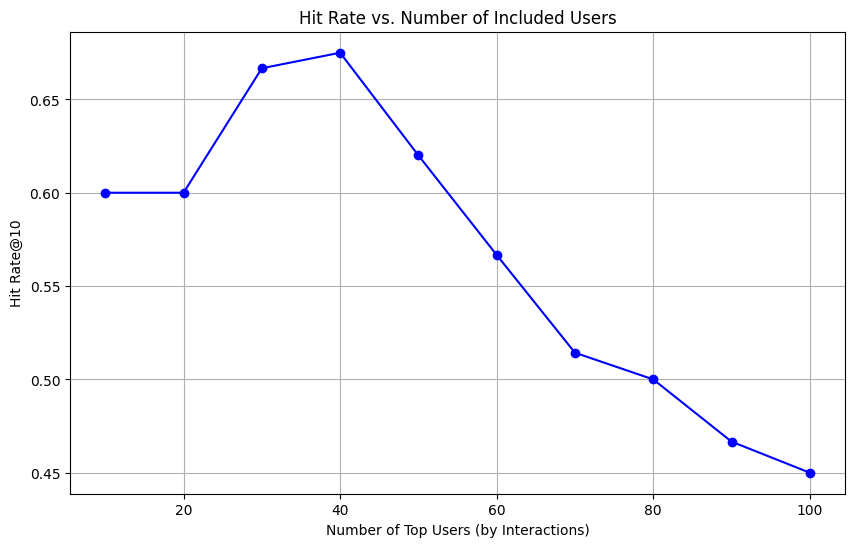

In [26]:
plot_hit_rate_vs_users(test_df, max_users=100, step=10)

In [22]:
def plot_hit_rate_vs_random_users(test_df, max_users, step):
    # Step 1: Get users sorted by interaction count descending
    user_interaction_counts = (
        test_df.groupby('user_id').count()
    )
    users = user_interaction_counts.index.tolist()

    # Step 2: Loop with cumulative hit calculation
    hit_rates = []
    total_hits = 0
    evaluated_users = 0

    for i in range(step, max_users + 1, step):
        current_batch = users[evaluated_users:i]
        hits_in_batch = sum(
            hits_at_k(user, test_df, get_recommendation, k=10)
            for user in current_batch
        )
        total_hits += hits_in_batch
        evaluated_users = i
        hit_rate = total_hits / evaluated_users
        hit_rates.append(hit_rate)

    # Step 3: Plot
    n_users_range = list(range(step, max_users + 1, step))
    plt.figure(figsize=(10, 6))
    plt.plot(n_users_range, hit_rates, marker='o', linestyle='-', color='b')
    plt.xlabel("Number of Top Users (by Interactions)")
    plt.ylabel("Hit Rate@10")
    plt.title("Hit Rate vs. Number of Included Users")
    plt.grid(True)
    plt.show()

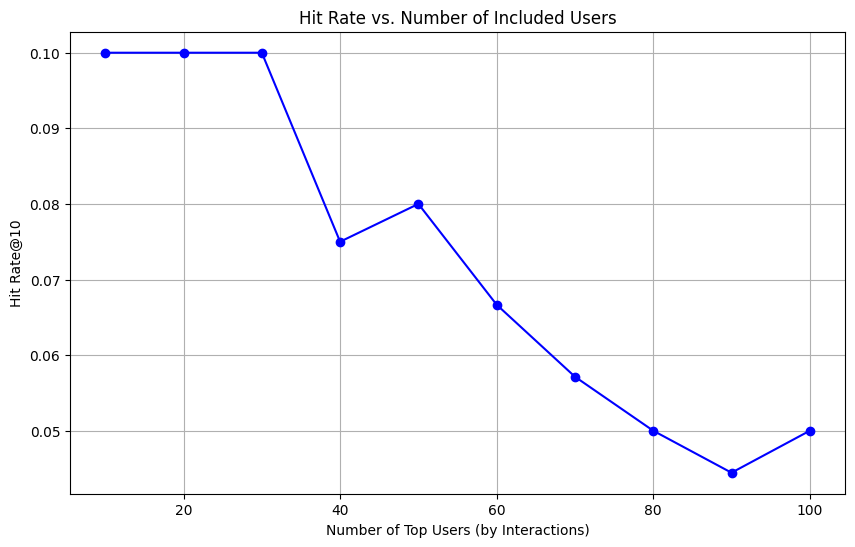

In [23]:
plot_hit_rate_vs_random_users(test_df, max_users=100, step=10)

### Evaluation NDCG

In [187]:
def dcg_at_k(relevance_scores, k):
    relevance_scores = np.asarray(relevance_scores)[:k]
    return np.sum((2**relevance_scores - 1) / np.log2(np.arange(2, relevance_scores.size + 2))) if relevance_scores.size else 0.

def ndcg_at_k(relevance_scores, k):
    dcg = dcg_at_k(relevance_scores, k)
    idcg = dcg_at_k(sorted(relevance_scores, reverse=True), k)
    return dcg / idcg if idcg > 0 else 0.

def get_ndcg_at_k(user, k=10):
    recommendations = get_recommendation(user, k)
    
    if recommendations.empty:
        return None
    
    #Get true items
    true_items = test_df[test_df['user_id'] == user][['business_id', 'stars']]
    
    recommendations = recommendations[['business_id', 'weighted_rank']]
    recommendations = recommendations.merge(true_items, on="business_id", how="left")
    
    recommendations = recommendations.sort_values(
        "weighted_rank", ascending=False)
    
    if recommendations["stars"].count() >= 2:
        relevance_scores = recommendations["stars"].dropna().tolist()
        ndcg = ndcg_at_k(relevance_scores, k)
        return ndcg
    else:
        return None


n_users = 1000
top_users = (
    test_df
    .groupby('user_id')
    .size()
    .sort_values(ascending=False)
    .head(n_users)
    .index.tolist()
)

# NDCG by top users
ndcg_scores = []
for user in top_users:
    ndcg = get_ndcg_at_k(user)
    if ndcg is not None:
        ndcg_scores.append(ndcg)

print("Mean NDCG@10: ", np.mean(ndcg_scores))

Mean NDCG@10:  0.9545641264396086


In [188]:
# NDCG by random select
n_users = 1000
user_interaction_counts = (
        test_df.groupby('user_id').count().head(n_users)
    )
random_users = user_interaction_counts.index.tolist()

ndcg_scores = []
for user in random_users:
    ndcg = get_ndcg_at_k(user)
    if ndcg is not None:
        ndcg_scores.append(ndcg)

print("Mean NDCG@10: ", np.mean(ndcg_scores))

C:\Users\user\AppData\Local\Temp\ipykernel_27544\2447303092.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restaurant_df['distance'] = np.sqrt(
C:\Users\user\AppData\Local\Temp\ipykernel_27544\2447303092.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restaurant_df['distance'] = np.sqrt(
C:\Users\user\AppData\Local\Temp\ipykernel_27544\2447303092.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

Mean NDCG@10:  0.8540645566659568
